# RNN for Sequence Modeling

Using a time series of  [Daily Minimum Temperatures in Melbourne](https://github.com/jbrownlee/Datasets/blob/master/daily-min-temperatures.csv)  from 1981 to 1990, we will build a model that can predict the Daily Minimum Tempereature for Melbourne in the future.

Table of Content:
- [1 - Data download and setup](#1)
- [2 - Train-Validation split](#2)
- [3 - Model building and Hyperparameter Tuning](#3)
- [4 - Tuning the number of epochs](#4)
- [5- Evaluating a model](#5)
- [6 - Save the model](#6)
- [7 - Bonus: Create spiral plot video](#7)

First let's download the data by runnin the following cell.

<a name = "1"></a>
### Data Download and setup

In [ ]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv

In [ ]:
import csv
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from datetime import datetime
import matplotlib.pyplot as plt
from dataclasses import dataclass
from matplotlib.animation import FuncAnimation

Define a function to parse the data

In [ ]:
def parse_data_from_file(filename):
  df = pd.read_csv(filename)
  time = df["Date"]
  series = df["Temp"]
  return df.index.to_list(), series.to_list()

And another fuction to visualize the series.

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

We will use a dataclass object to save all our global variables.

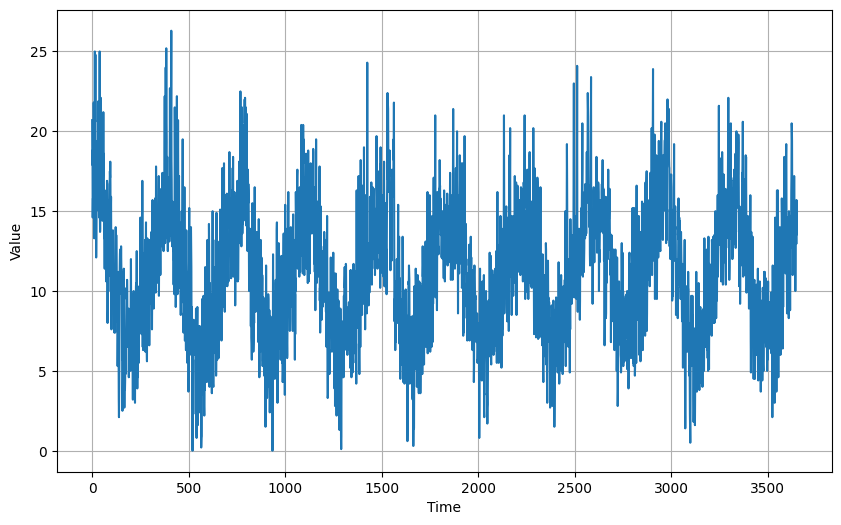

In [ ]:
# Define all variables variables within the G class (G stands for global)
@dataclass
class G:
    TEMPERATURES_CSV = './daily-min-temperatures.csv'
    times, temperatures = parse_data_from_file(TEMPERATURES_CSV)
    TIME = np.array(times)
    SERIES = np.array(temperatures)
    SPLIT_TIME = 2500
    WINDOW_SIZE = 64
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000


plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

<a name = "2"></a>
### Train - Validation split

In [ ]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

Convert the data to windowed dataset.

In [ ]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)
valid_set = windowed_dataset(series_valid, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

<a name = "3"></a>
### Build model and use `keras_tuner` for hyperparameter tuning.

In [ ]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 6.6 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt

If the hyperparameter tuning needs to be run again, uncomment the following cell to remove the directory with results of previous hyperparameter tuning.

In [ ]:
#rm -r my_dir

In [ ]:
def create_uncompiled_model(hp):

    hp_units1 = hp.Int('units1', min_value=16, max_value=128, step=16)
    hp_units2 = hp.Int('units2', min_value=32, max_value=128, step=16)

    model = keras.models.Sequential([
            keras.layers.Conv1D(filters=hp_units1, kernel_size=3,
                                strides=1,
                                activation="relu",
                                padding='causal',
                                input_shape=[G.WINDOW_SIZE, 1]),
            keras.layers.LSTM(hp_units2, return_sequences=True),
            keras.layers.LSTM(64),
            keras.layers.Dense(30, activation="relu"),
            keras.layers.Dense(10, activation="relu"),
            keras.layers.Dense(1, activation  = "relu"),
            keras.layers.Lambda(lambda x: x * 25)
          ])

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 2e-3, 4e-3, 7e-3, 1e-3, 1e-4, 1e-5, 1e-6])

    model.compile(optimizer=tf.keras.optimizers.SGD(momentum = 0.9, learning_rate=hp_learning_rate),
                loss=tf.keras.losses.Huber(),
                metrics=['mae'])

    return model

In [ ]:
tuner = kt.Hyperband(create_uncompiled_model,
                     objective=kt.Objective('val_mae', direction='min'),
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

Add a callback function to use early stopping if the model is not learning.

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
tuner.search(train_set, epochs=50, validation_data=valid_set, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the Conv1D
layer is {best_hps.get('units1')}, for the first LSTM layer is {best_hps.get('units2')}.
""")

Trial 30 Complete [00h 01m 01s]
val_mae: 11.602852821350098

Best val_mae So Far: 1.8361650705337524
Total elapsed time: 00h 27m 39s

The hyperparameter search is complete. The optimal number of units in the Conv1D
layer is 64, for the first LSTM layer is 64.



<a name = "4"></a>
### Tune the epochs
First build the model with best hyperparameters and train it for a some epochs.

In [ ]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_set, epochs=50, validation_data = valid_set)

val_mae_per_epoch = history.history['val_mae']
best_epoch = val_mae_per_epoch.index(min(val_mae_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Retrain the model to the optimum number of epochs

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(train_set, epochs=best_epoch, validation_data = valid_set)

<a name = "5"></a>
### Evaluating the Model
Compute __Mean Squared Error__ `mse` and __Mean Absolute Error__ `mae` with actual and forecasted values.

In [ ]:
def compute_metrics(true_series, forecast):

    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

The function below will return the model forecast, which can be used for evaluation.

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

114/114 [==============================] - 5s 33ms/step


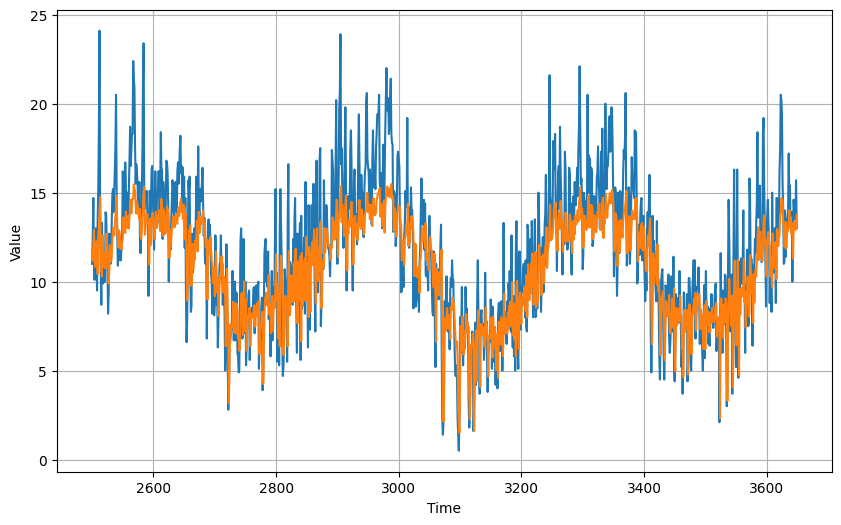

In [ ]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 6.36, mae: 1.97 for forecast


<a name = "6"></a>
### Save the model

In [ ]:
model.save('model.h5')

<a name = "7"></a>
### Create a video of Spiral Plot

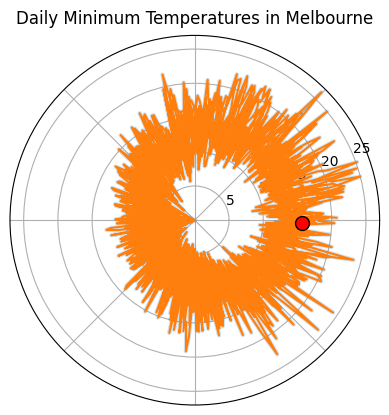

In [ ]:
r = df["Temp"]
years = df["Date"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").year)
theta = ((df["Date"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").timetuple().tm_yday)) * np.pi * 2/365.25)

# Add another plot command to show a big red point at the current data point
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
line, = ax.plot([], [], linewidth=3, alpha = 0.2, ) # make line thicker
point, = ax.plot([], [], marker='o', markersize=10, markerfacecolor='red', markeredgecolor='black', markevery=[-1]) # add a big red point
ax.set_rmax(27)
ax.grid(True)
ax.set_title("Daily Minimum Temperatures in Melbourne", va='bottom')

# Remove angular tick labels
plt.tick_params(labelbottom=False)

# Define the update function for animation
def update(i):
  line.set_xdata(theta[:i])
  if theta[i] == 0:
    line.set_title(years[i])
  line.set_ydata(r[:i])
  point.set_xdata(theta[:i]) # set x data for point
  point.set_ydata(r[:i]) # set y data for point
  return line, point # return both line and point
# Create the animation object
ani = FuncAnimation(fig, update, frames=len(r), interval=50, blit=True)
ani.save("animate.mp4")
plt.show()